In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sps
from collections import defaultdict
from time import sleep
from subprocess import Popen, PIPE, STDOUT, TimeoutExpired
from tqdm.auto import tqdm
import graph_tool.all as gr
from multiprocessing import Pool

import subprocess

sns.set(font_scale=1.5, style='darkgrid', palette='Set2')

In [3]:
def get_pair(i):
    k = np.floor((1 + np.sqrt(1 + 8 * i)) / 2)
    m = i - k * (k - 1) / 2
    
    return int(k), int(m)


# def get_graph(i, n):
#     m = int(n * (n - 1) / 2)
#     edges = defaultdict(list)
    
#     for j in range(m):
#         if (i >> j) & 1 == 1:
#             u, v = get_pair(j)
#             edges[u].append(v)
#             edges[v].append(u)
    
#     return edges


def get_graph_from_list(l):
    edges = defaultdict(list)
    num = 0
    
    for i, byte in enumerate(l):
        if byte == 1:
            num += 1
            u, v = get_pair(i)
            edges[u].append(v)
    
    return num, edges


def get_graph(code):
    parse = list(map(lambda x: f'{ord(x) - 63:06b}', code))
    n = int(parse[0], 2)
    m = int(n * (n - 1) / 2)
    parse = list(map(int, ''.join(parse[1:])[:m]))
    
    return get_graph_from_list(parse)
    

def draw_graph(n, edges, colors=None):
    graph = gr.Graph(directed=False)
    
    vertexes = list(graph.add_vertex(n))
    for u in edges:
        for v in edges[u]:
            graph.add_edge(vertexes[u], vertexes[v])
            
    v_text = graph.new_vertex_property("string")
    for i, v in enumerate(vertexes):
        v_text[v] = f'{i}'
        
    v_colors = graph.new_vertex_property('vector<double>')
    if colors is None:
        for v in vertexes:
            v_colors[v] = [0.640625, 0, 0, 0.9]
    else:
        for i, v in enumerate(vertexes):
            color = [0, 0, 0, 0.9]
            color[colors[i]] = 0.640625
            v_colors[v] = color
            
    gr.graph_draw(graph, vertex_text=v_text, vertex_fill_color=v_colors)
    
    
def get_output(input_data): 
    p = Popen(['./build/3coloring'], stdout=PIPE, stdin=PIPE, stderr=PIPE)
    try:
        out = p.communicate(timeout=3, input=input_data.encode())
        return out[0].decode()
    except TimeoutExpired:
        p.kill()
        return None


def test_graphs(n):    
    error = False
    
    with open(f'data/graph{n}.g6', 'r') as data:
        for i, code in tqdm(enumerate(data)):
            m, edges = get_graph(code)
            
            input_data = f'{n} {m}\n'
            for v in edges:
                for u in edges[v]:
                    input_data += f'{v} {u}\n'
                    
            input_data_stupid = input_data + 'stupid\n'
            input_data_fast = input_data + 'fast\n'
            
#             if i >= 4446:
#                 draw_graph(n, edges)
#                 print(input_data, dict(edges))
            
            stdout_stupid = get_output(input_data_stupid)
            stdout_fast = get_output(input_data_fast)
            
            if stdout_fast is None or stdout_stupid is None or stdout_fast[0] != stdout_stupid[0]:
                print(f'Error {i}: fast = {stdout_fast[0]}, stupid = {stdout_stupid[0]}')
                draw_graph(n, edges)
                print('Data:', input_data)
                print('Edges:', dict(edges), '\n\n')
                error = True
                
            
    if not error:
        print('OK!')
    else:
        print('ERROR!')   

In [22]:
for n in range(4, 9):
    test_graphs(n)

0it [00:00, ?it/s]

OK!


0it [00:00, ?it/s]

OK!


0it [00:00, ?it/s]

OK!


0it [00:00, ?it/s]

OK!


0it [00:00, ?it/s]

OK!


In [ ]:
test_graphs(9)

In [4]:
def launch_program(n, m, edges, fast=True):
    input_data = f'{n} {m}\n'
    
    for v in edges:
        for u in edges[v]:
            input_data += f'{v} {u}\n'

    input_data += 'fast\n' if fast else 'stupid\n'

    stdout = get_output(input_data)
    
    if stdout is None:
        return np.NaN, np.NaN
    
    if stdout is None or len(stdout.split('\n')) < 2:
        print(f'Error:')
        print(stdout)
        draw_graph(n, edges)
        print('Data:', input_data)
        print('Edges:', dict(edges), '\n\n')
        return np.NaN, np.NaN
    
    stdout = stdout.split('\n')
    ans = int(stdout[0])
    time = int(stdout[1])
    
    return ans, time


def test_random_graphs(n, p, count):
    m = int(n * (n - 1) / 2)
    samples = sps.rv_discrete(values=[[0, 1], [1 - p, p]]).rvs(size=(count, m))
    
    times_f = [[], []]
    times_s = [[], []]
    
    args_fast = []
    args_stupid = []
    
    for code in samples:
        num, edges = get_graph_from_list(code)
        
        args_fast.append([n, num, edges, True])
        args_stupid.append([n, num, edges, False])
        
    
    with Pool(processes=6) as pool:
#         print(pool.starmap(test_func, [[1, 2, 3], ] * 6))
        ret_fast = np.array(pool.starmap(launch_program, args_fast)).T
        ret_stupid = np.array([[], []])
#         if n < 18:
        ret_stupid = np.array(pool.starmap(launch_program, args_stupid)).T
        
#         ans_f, time_f = launch_program(n, num, edges, fast=True)
#         ans_s, time_s = launch_program(n, num, edges, fast=False)
    
        t_fast_true = ret_fast[1][ret_fast[0] == 1]
        t_fast_false = ret_fast[1][ret_fast[0] == 0]
        t_stupid_true = ret_stupid[1][ret_stupid[0] == 1]
        t_stupid_false = ret_stupid[1][ret_stupid[0] == 0]
#         print(ans, time)
    
    return np.array(t_fast_false if (len(t_fast_false) > 0) else [0, ]), \
           np.array(t_fast_true if (len(t_fast_true) > 0) else [0, ]), \
           np.array(t_stupid_false if (len(t_stupid_false) > 0) else [0, ]), \
           np.array(t_stupid_true if (len(t_stupid_true) > 0) else [0, ])


def draw_plots(p, count=10, min_n=5, max_n=50, step=1):
    avg_time = {'false_fast': [], 'true_fast': [], 
                'false_stupid': [], 'true_stupid': []}
    
    for n in tqdm(range(min_n, max_n, step)):
        time_false_fast, time_true_fast, time_false_stupid, time_true_stupid = \
            test_random_graphs(n, p, count)
        
        avg_time['false_fast'].append(time_false_fast.mean())
        avg_time['true_fast'].append(time_true_fast.mean())
        avg_time['false_stupid'].append(time_false_stupid.mean())
        avg_time['true_stupid'].append(time_true_stupid.mean())
    
    grid = np.arange(min_n, max_n, step)
    theoretical_time = 1.3478**grid
    
    for with_stupid in [False, True]:
        for scale in ['linear', 'log']:
            plt.figure(figsize=(15, 7))
            for i, key in enumerate(avg_time):
                if not with_stupid and 'stupid' in key:
                    continue
                plt.plot(grid, avg_time[key], label=key)
            
            max_val = max(avg_time['true_fast'][-1], avg_time['false_fast'][-1])
            if with_stupid:
                max_val = max(avg_time['false_stupid'][-1], avg_time['true_stupid'][-1], max_val)
            
            theoretical_time = theoretical_time * max_val / theoretical_time.max()
            plt.plot(grid, theoretical_time, label='theoretical')

            plt.legend()
            plt.yscale(scale)
            plt.title('Зависимость среднего времени работы от количества вершин')
            plt.xlabel('Количество вершин')
            plt.ylabel('Среднее время')
            plt.savefig(f'plots/{p}_{count}_{scale}_{with_stupid}.png')
            plt.show()

  0%|          | 0/45 [00:00<?, ?it/s]

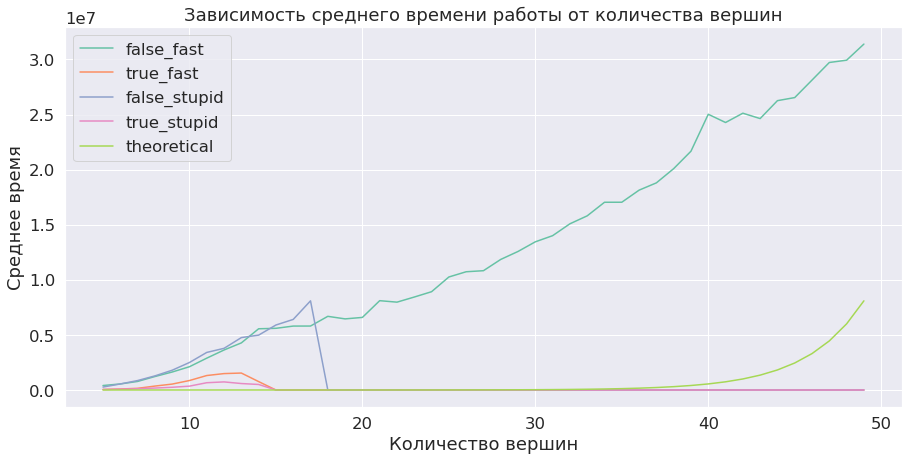

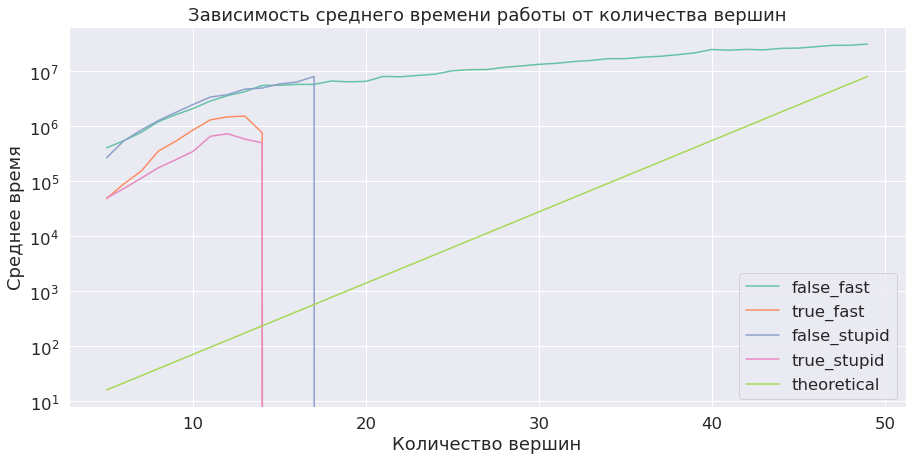

  0%|          | 0/45 [00:00<?, ?it/s]

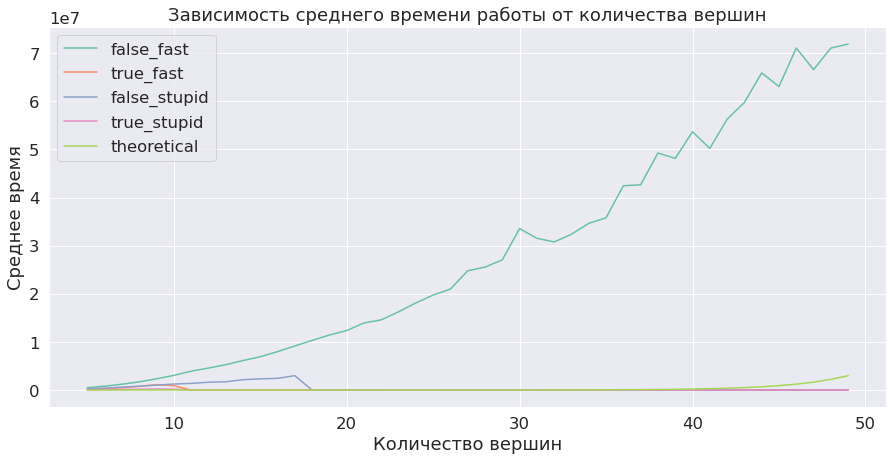

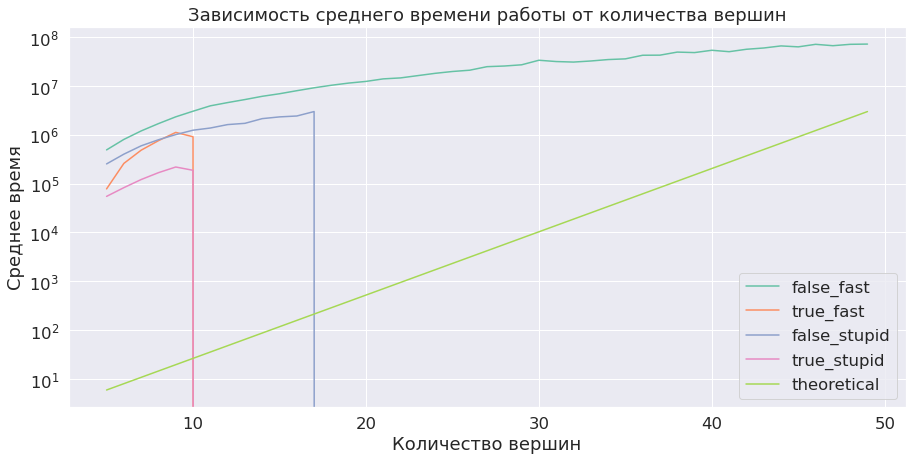

  0%|          | 0/45 [00:00<?, ?it/s]

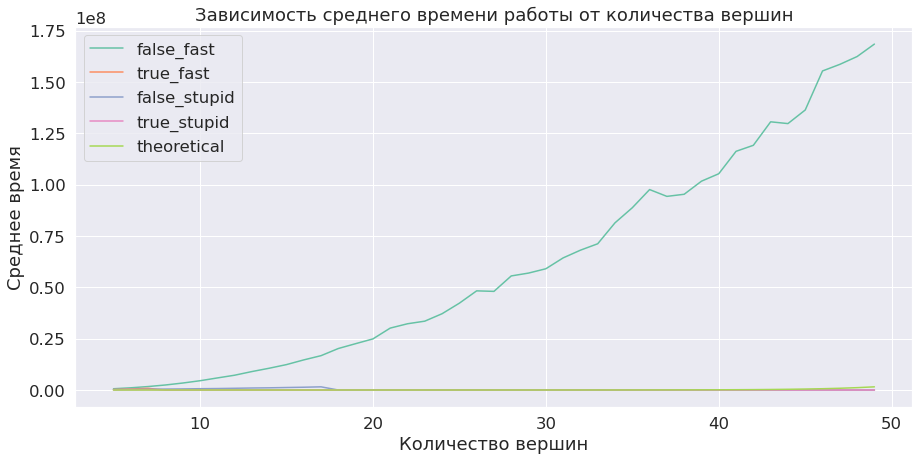

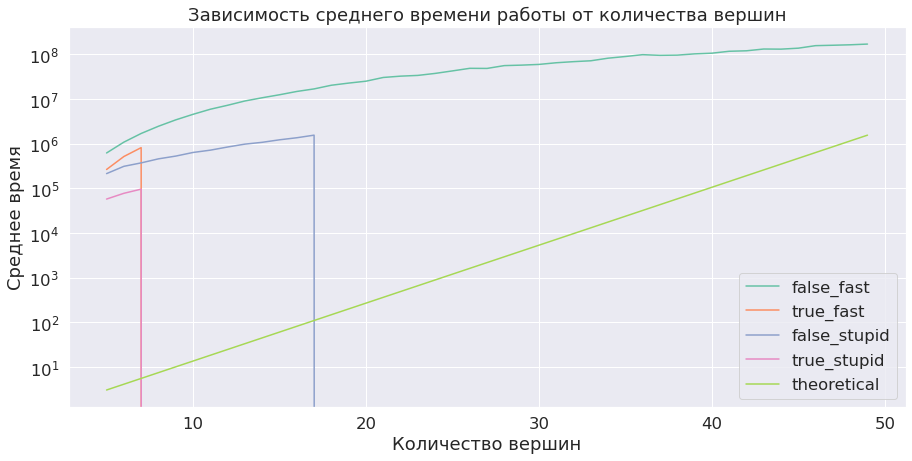

  0%|          | 0/45 [00:00<?, ?it/s]

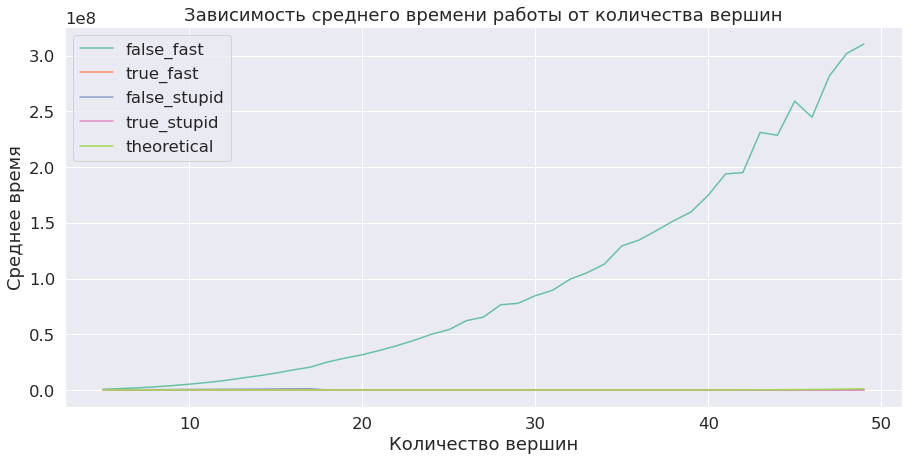

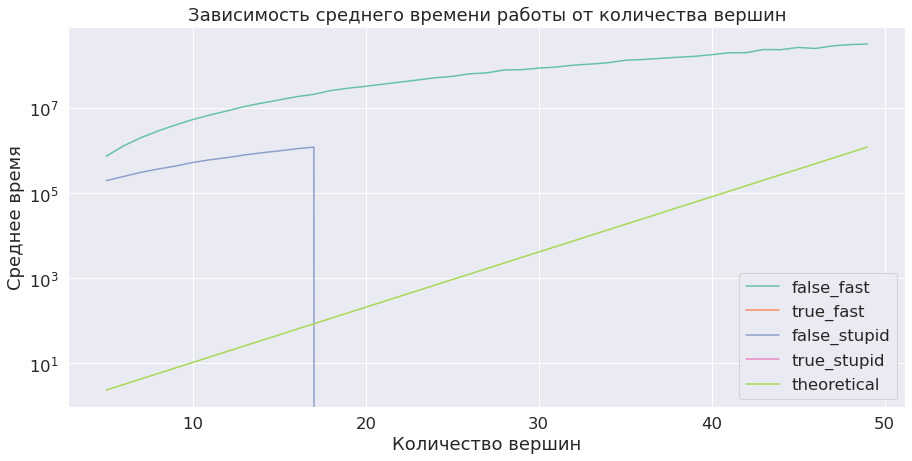

In [35]:
for p, max_n in zip([0.5, 0.7, 0.9, 0.99], [50, 50, 50, 50]):
    draw_plots(p, 500, max_n=max_n)

  0%|          | 0/45 [00:00<?, ?it/s]

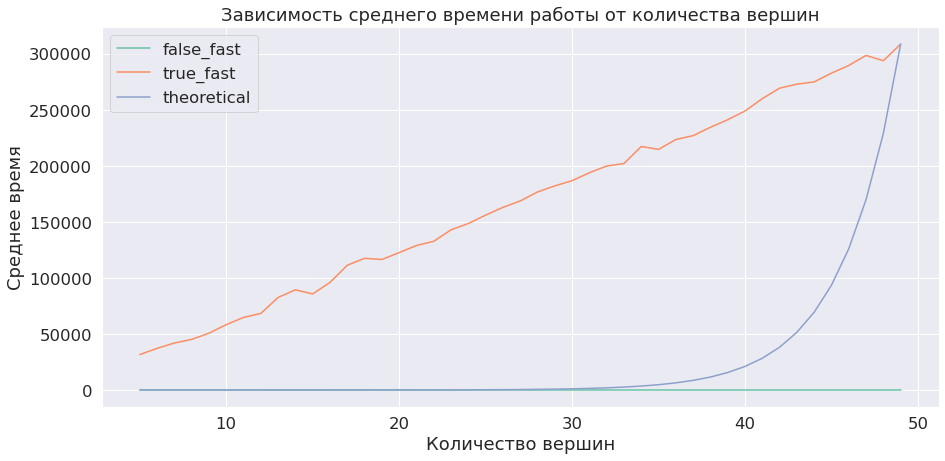

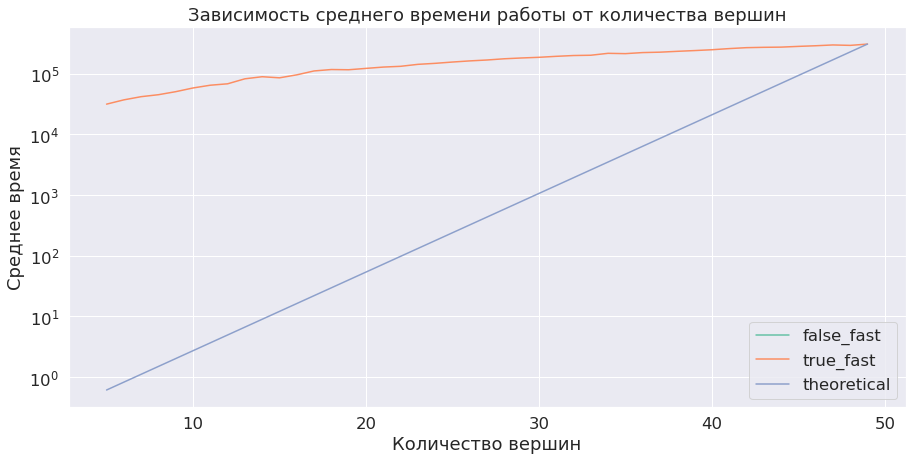

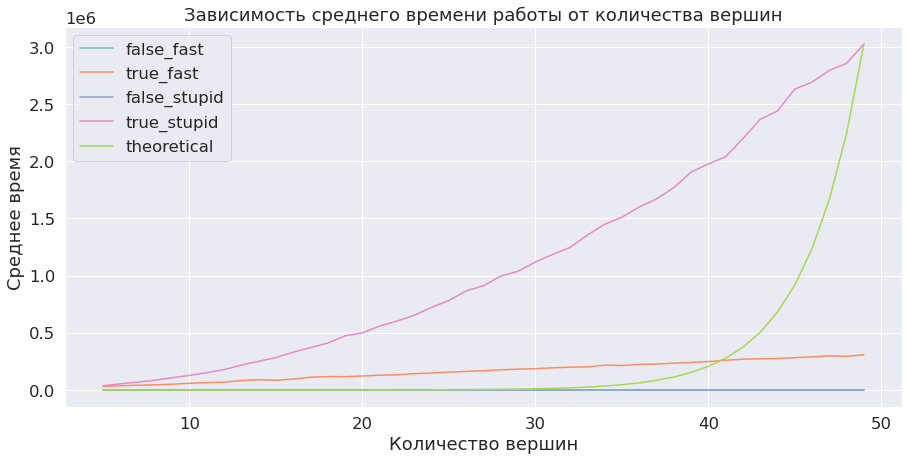

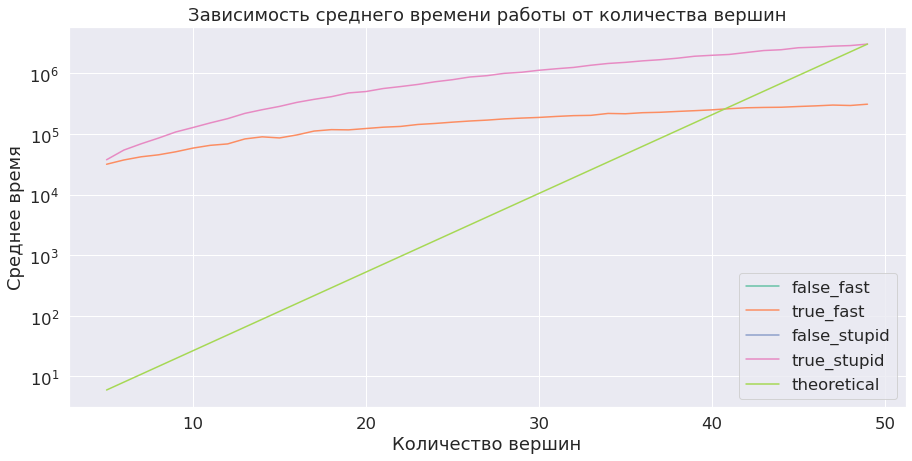

  0%|          | 0/35 [00:00<?, ?it/s]

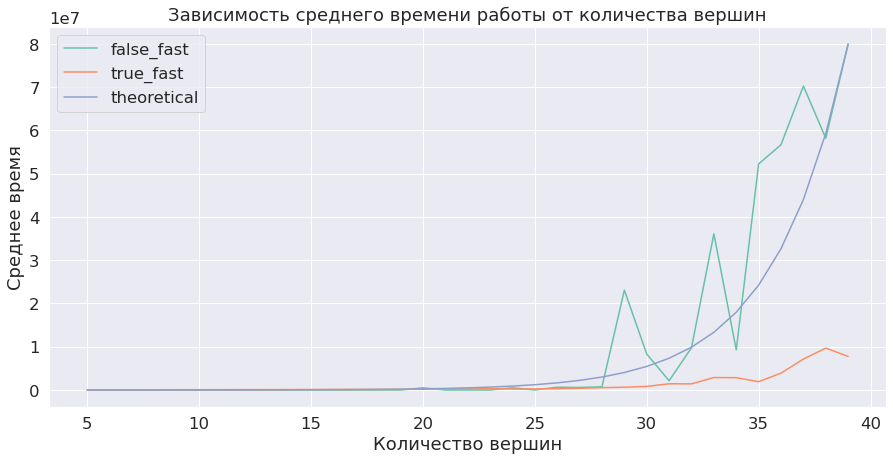

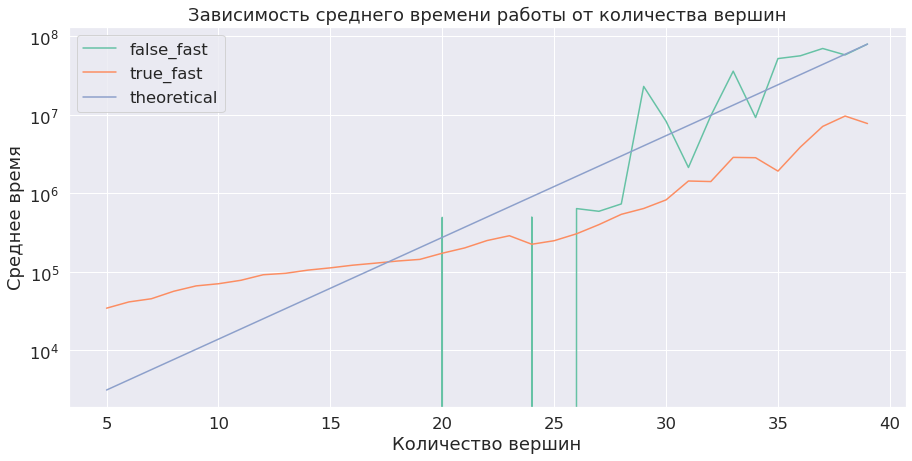

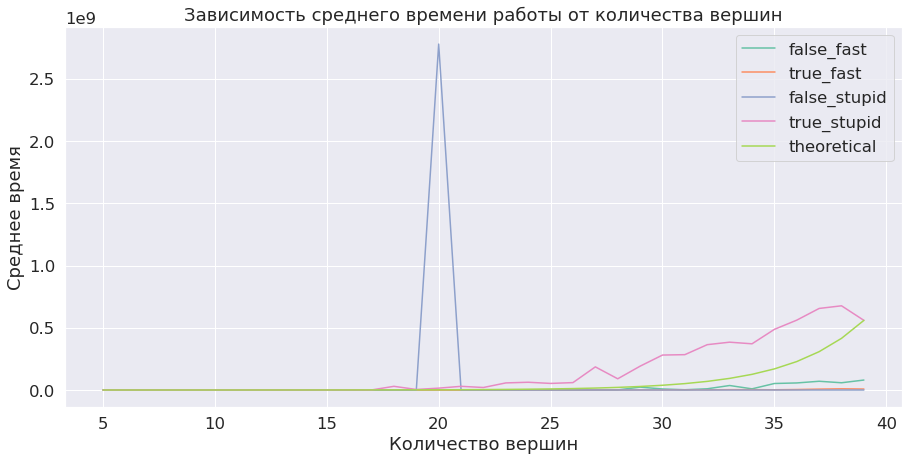

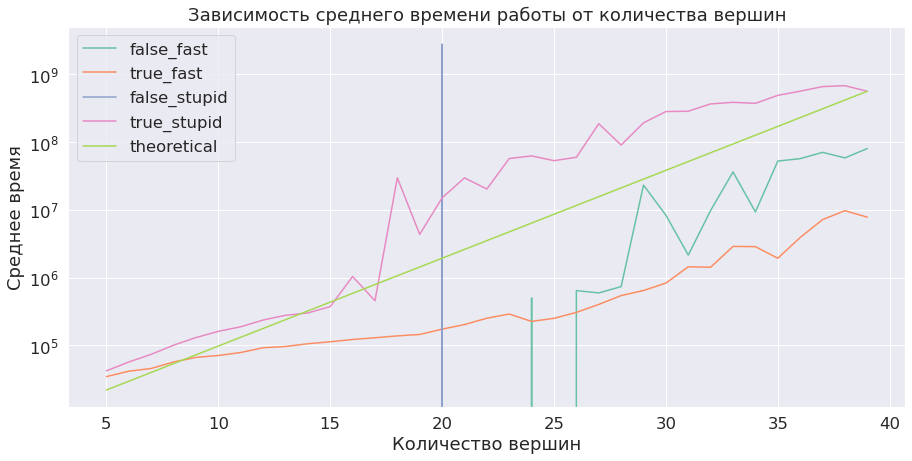

  0%|          | 0/45 [00:00<?, ?it/s]

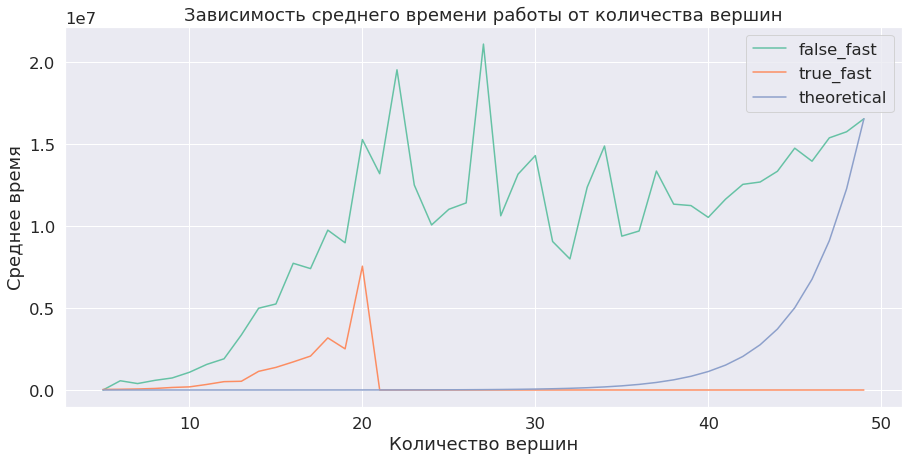

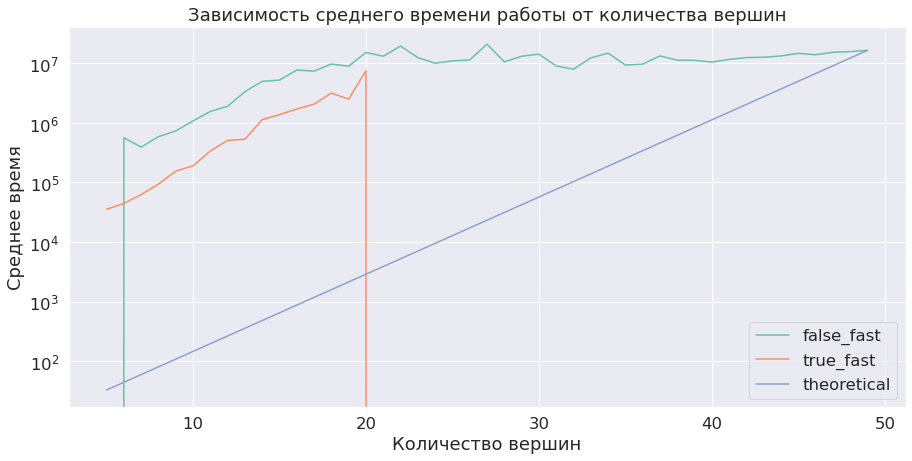

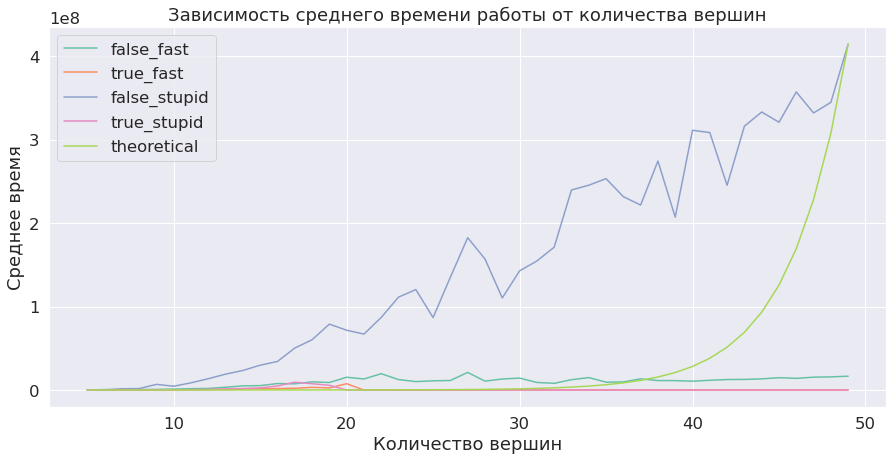

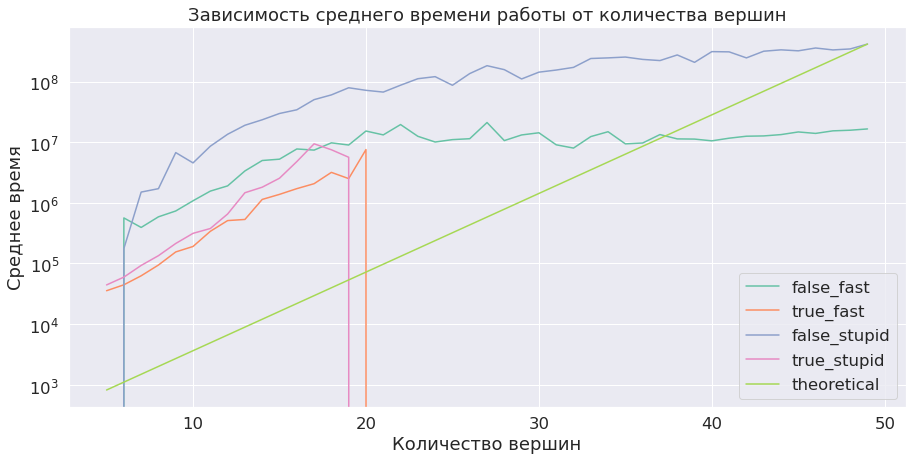

  0%|          | 0/45 [00:00<?, ?it/s]

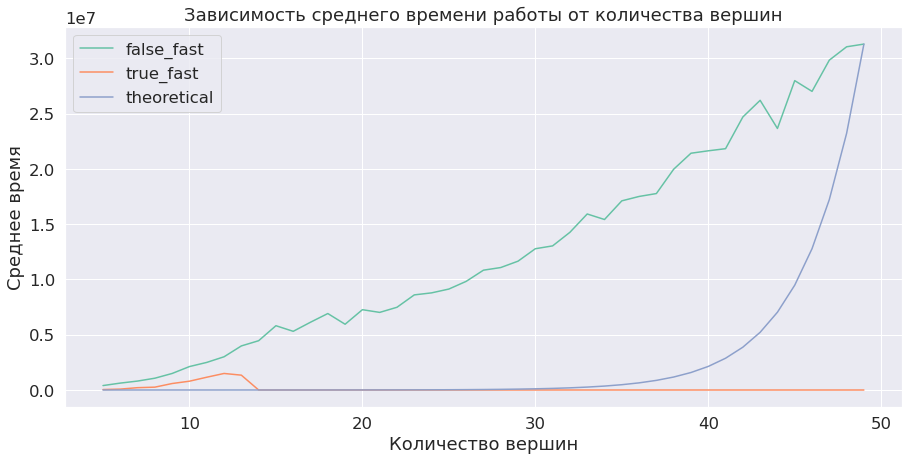

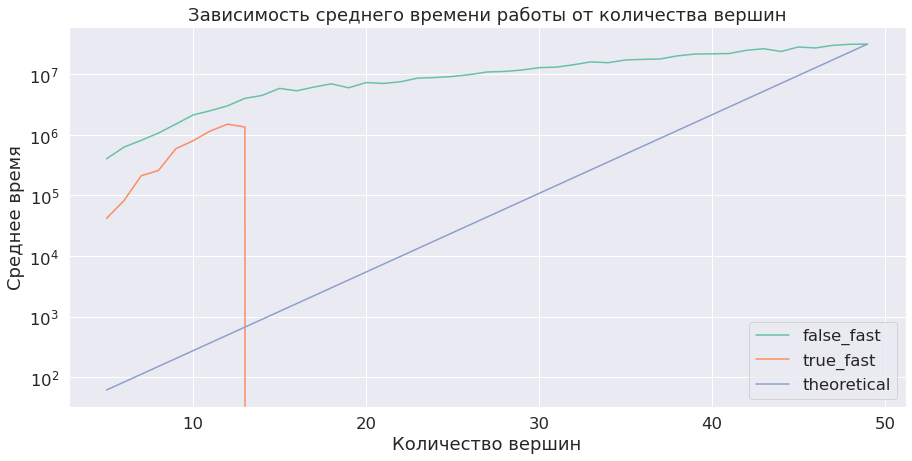

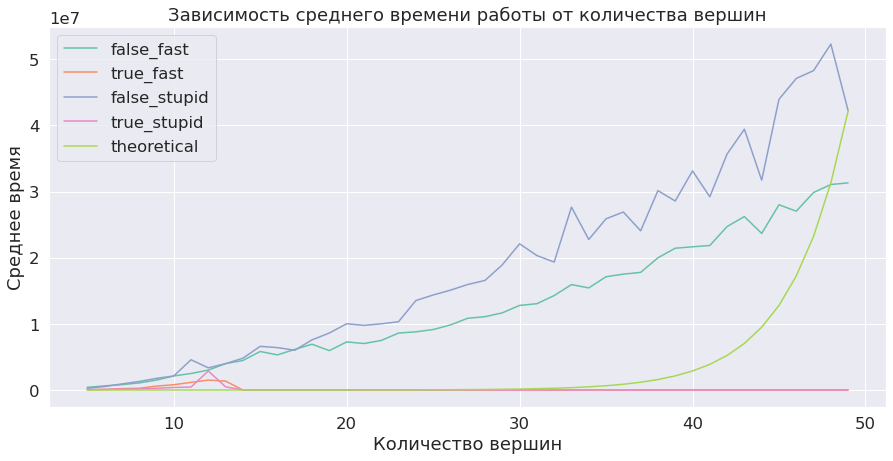

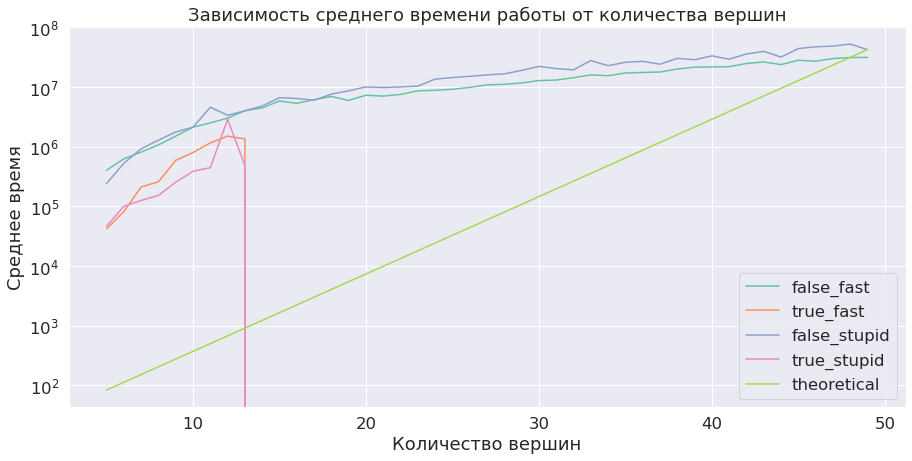

  0%|          | 0/45 [00:00<?, ?it/s]

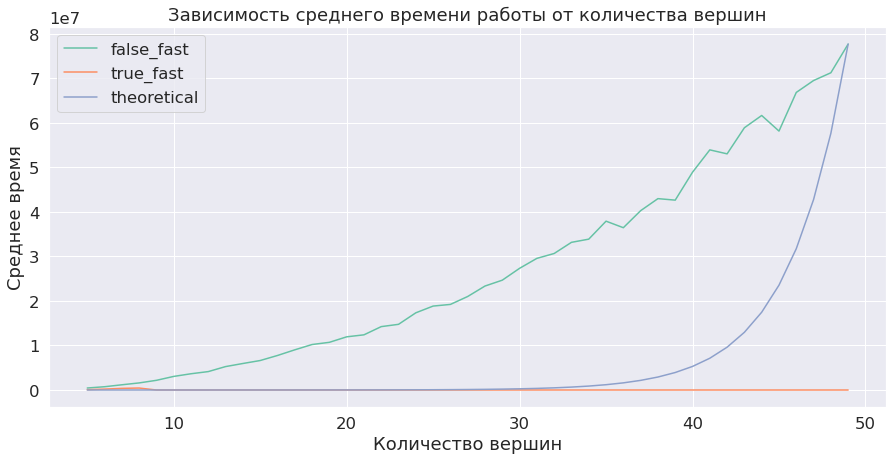

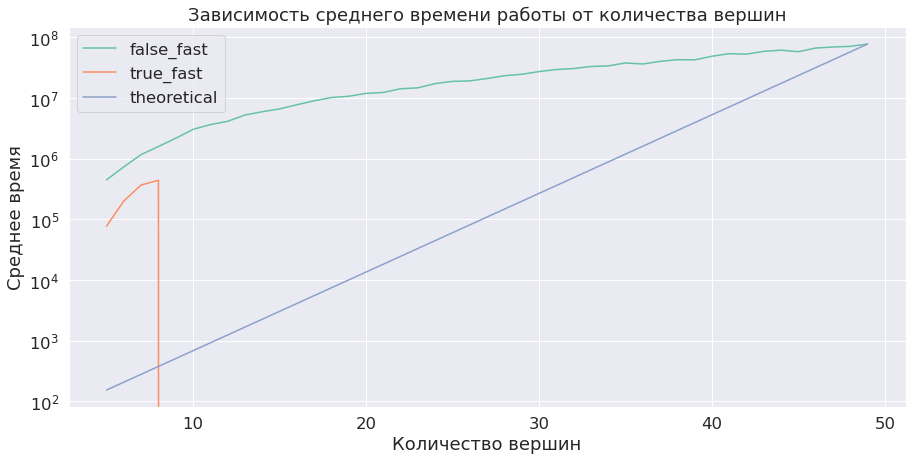

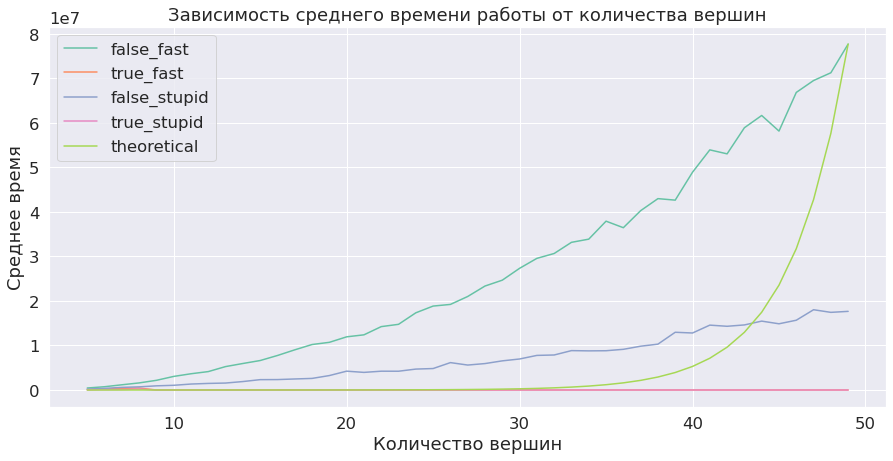

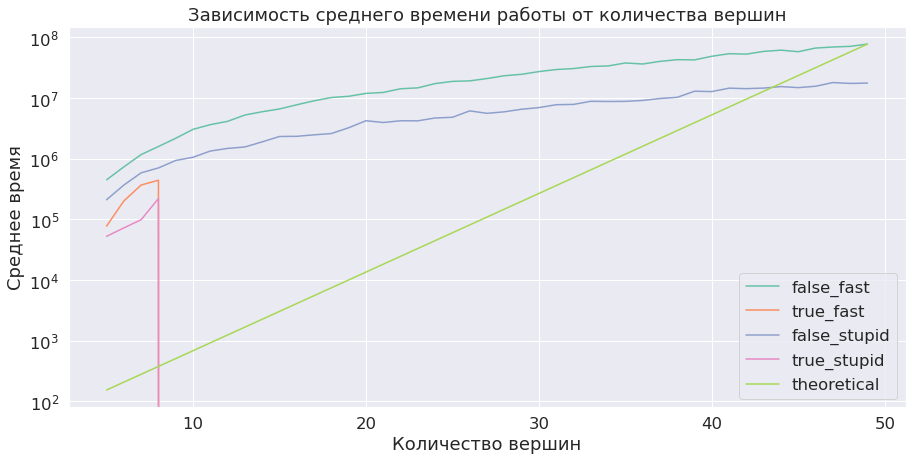

  0%|          | 0/45 [00:00<?, ?it/s]

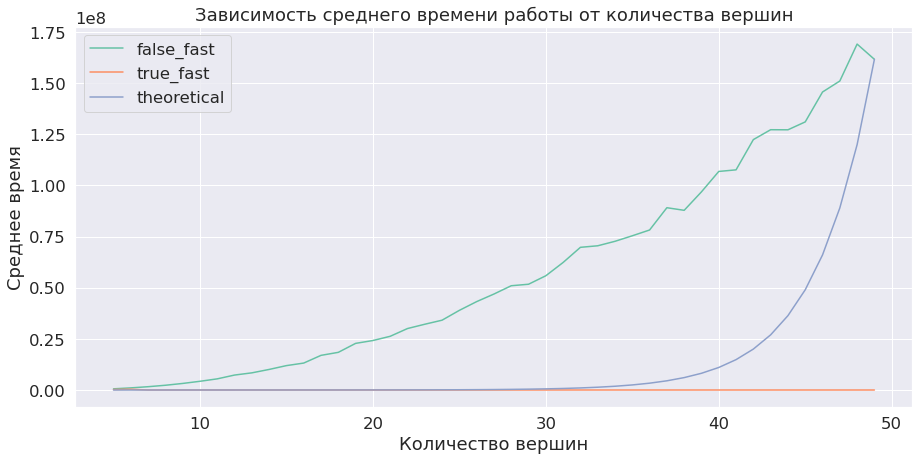

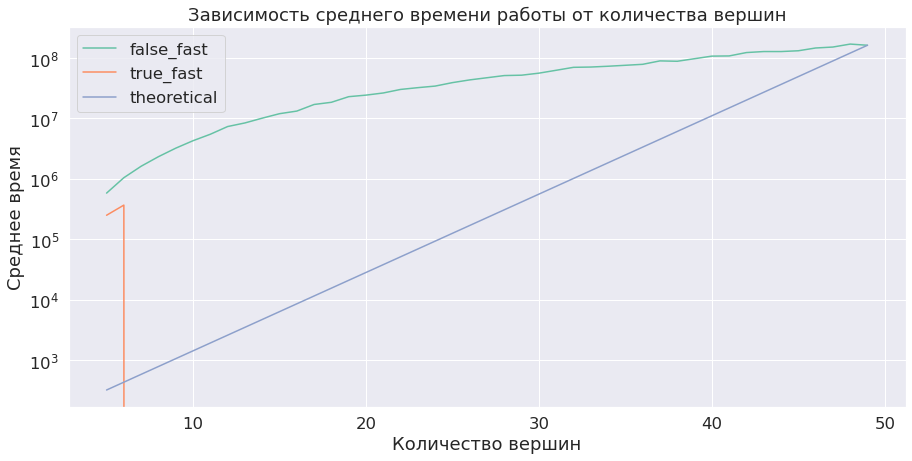

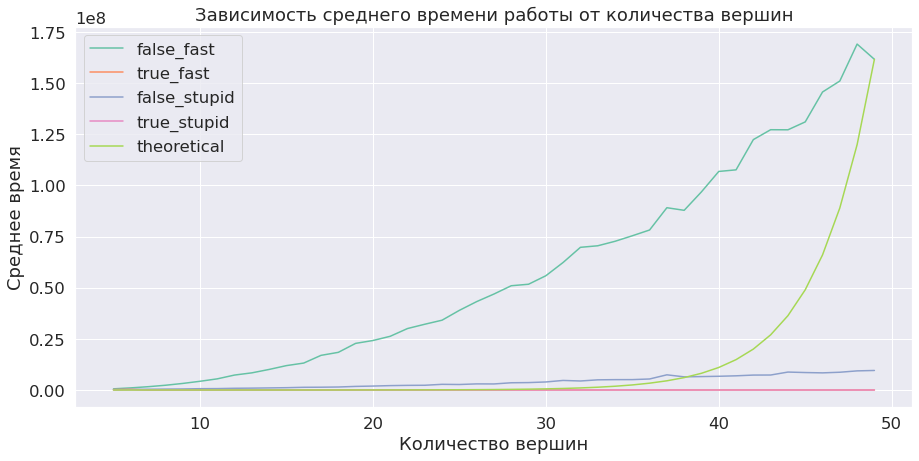

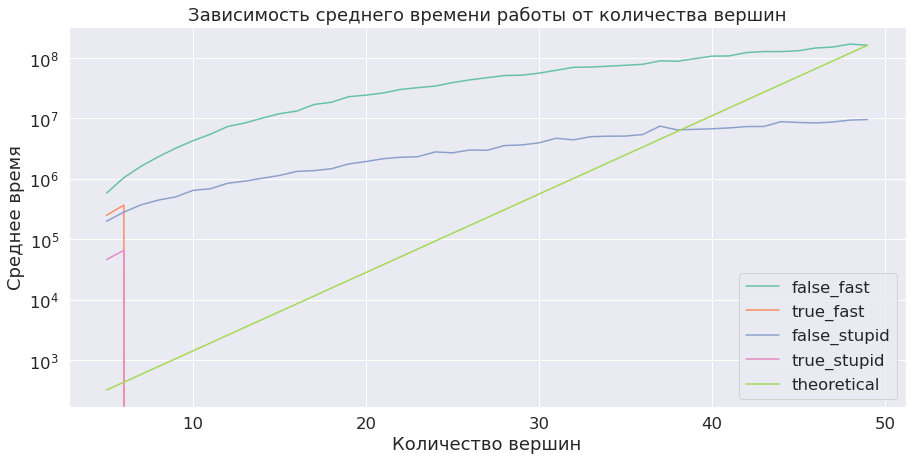

  0%|          | 0/45 [00:00<?, ?it/s]

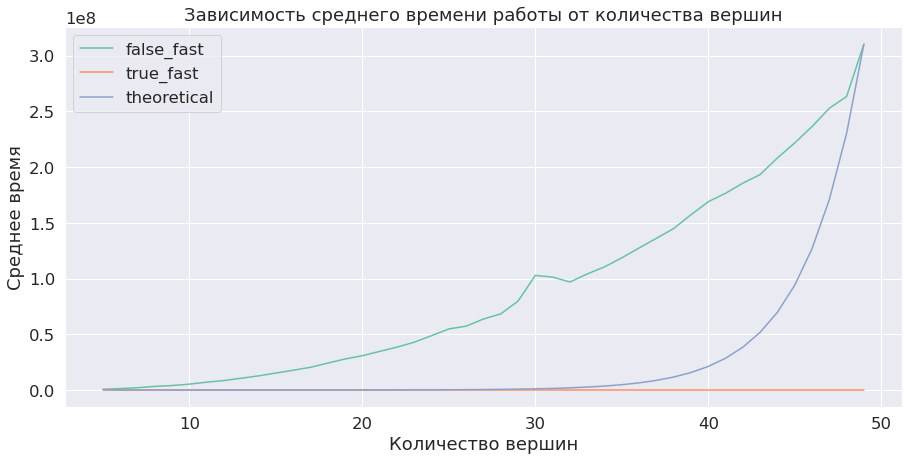

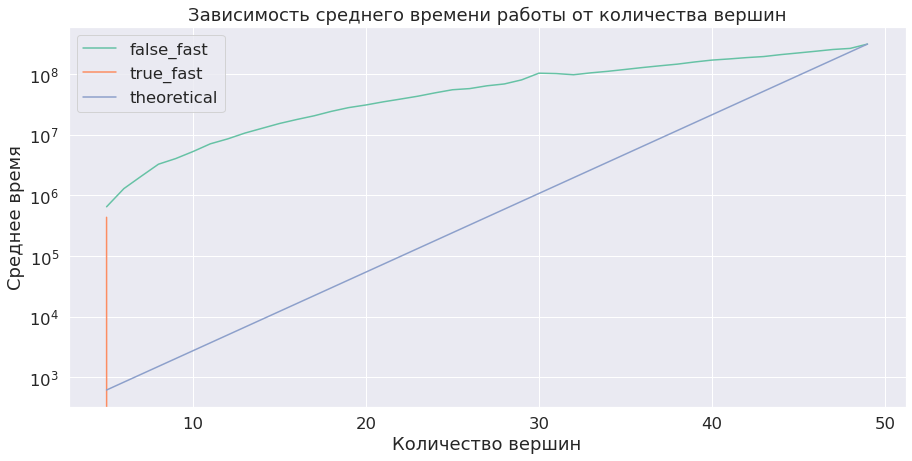

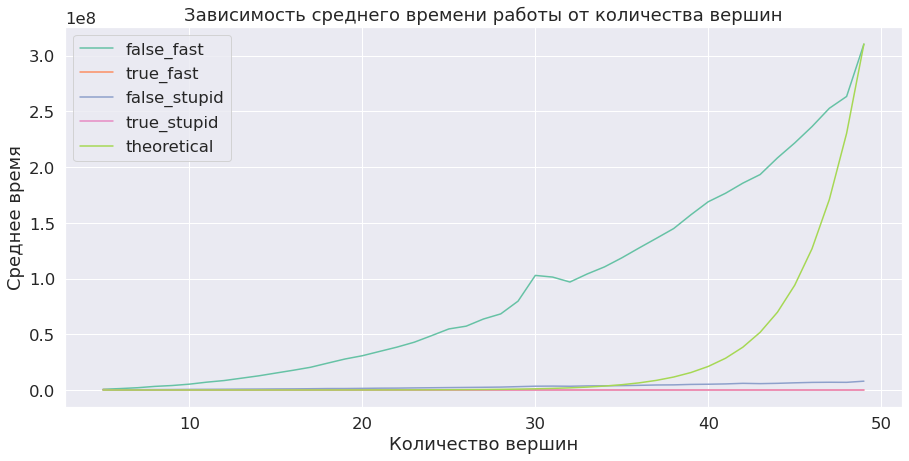

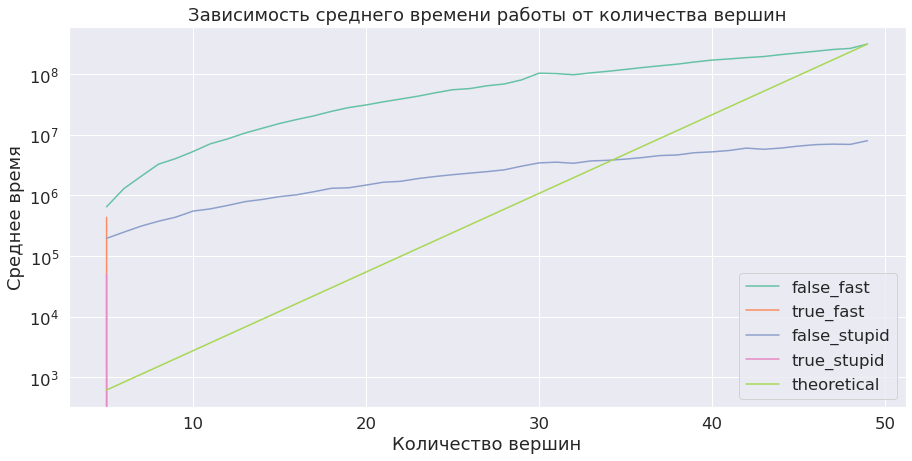

In [42]:
for p, max_n in zip([0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 0.99], [50, 35, 50, 50, 50, 50, 50]):
    draw_plots(p, 100, max_n=max_n)

  0%|          | 0/45 [00:00<?, ?it/s]

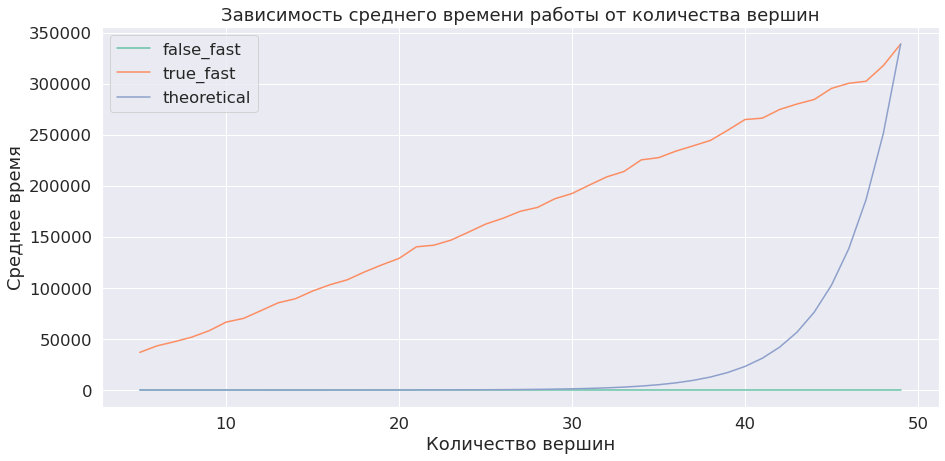

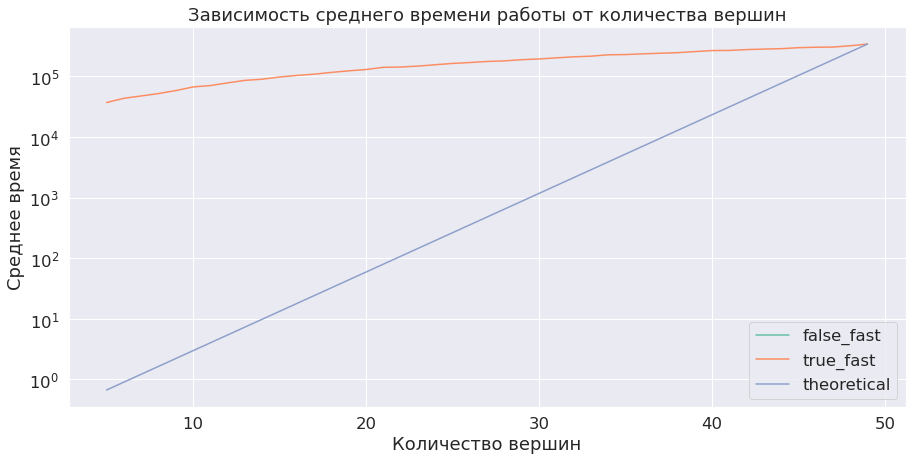

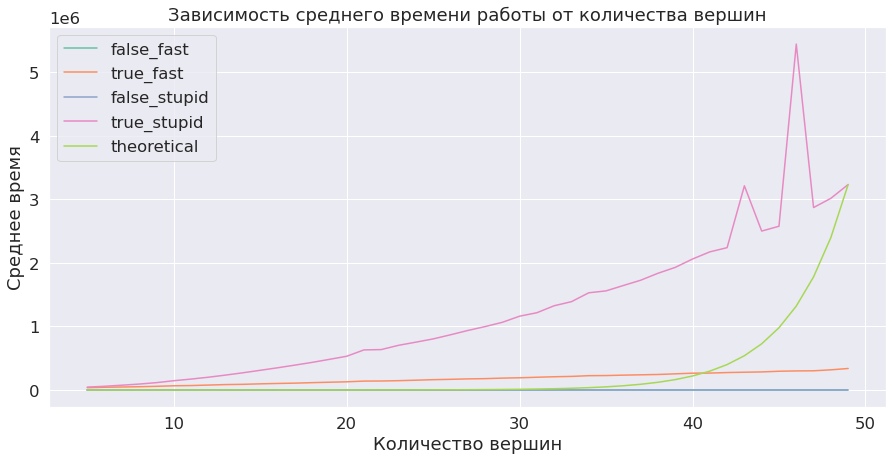

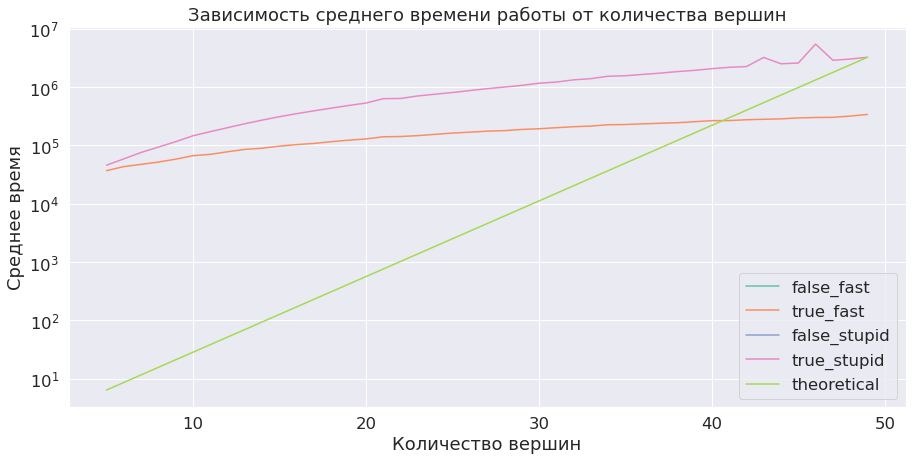

  0%|          | 0/25 [00:00<?, ?it/s]

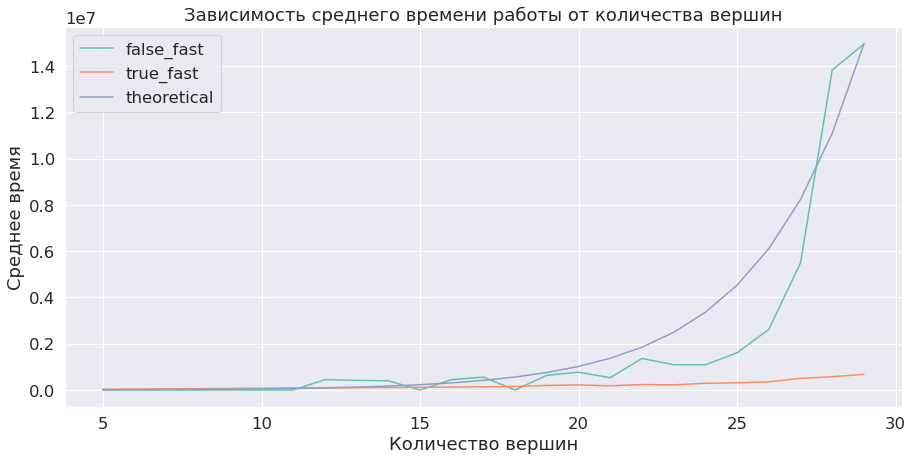

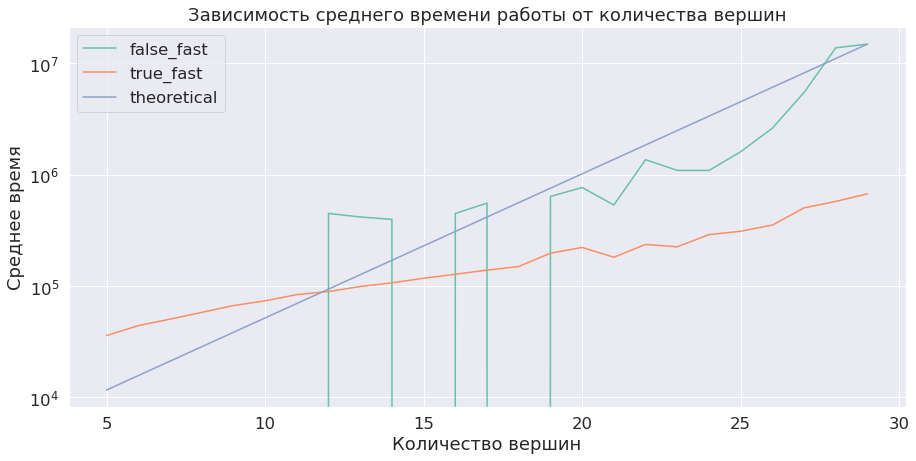

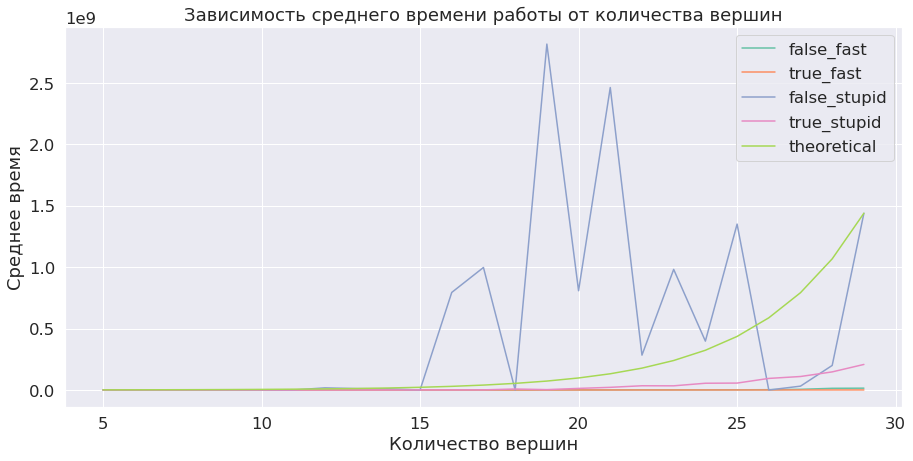

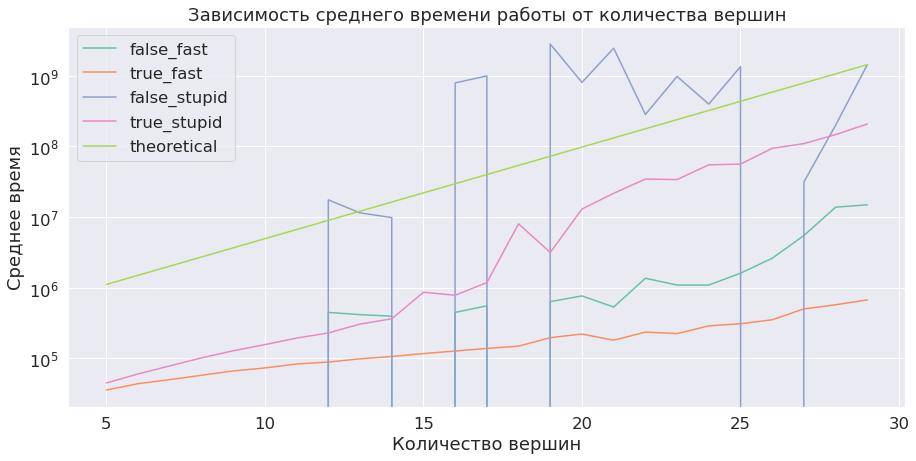

  0%|          | 0/45 [00:00<?, ?it/s]

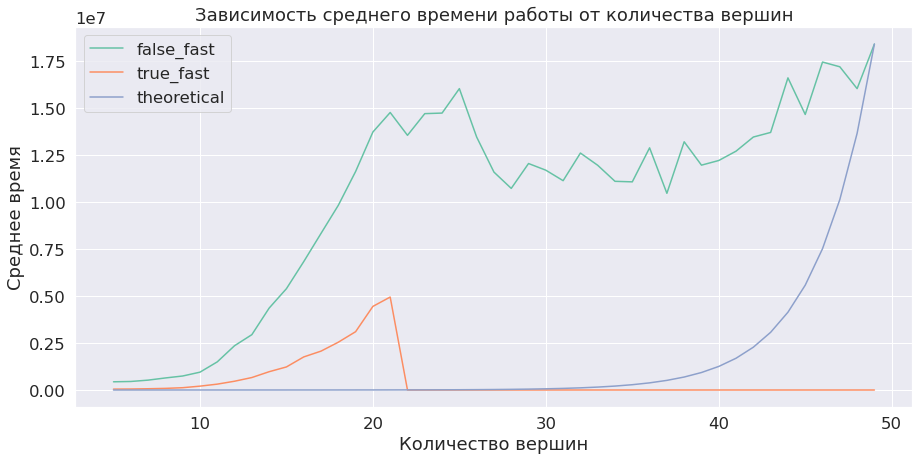

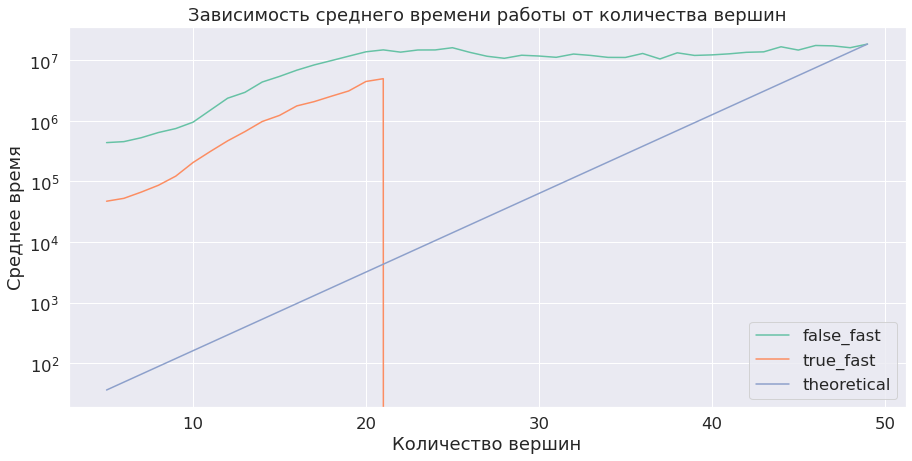

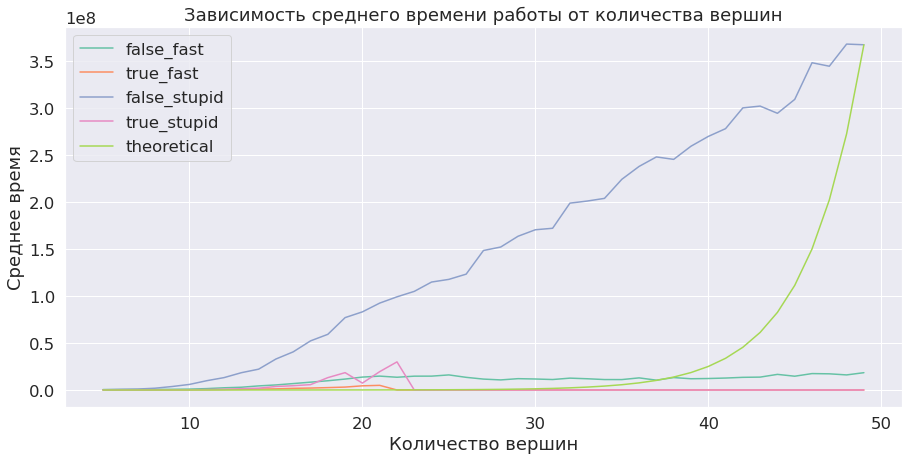

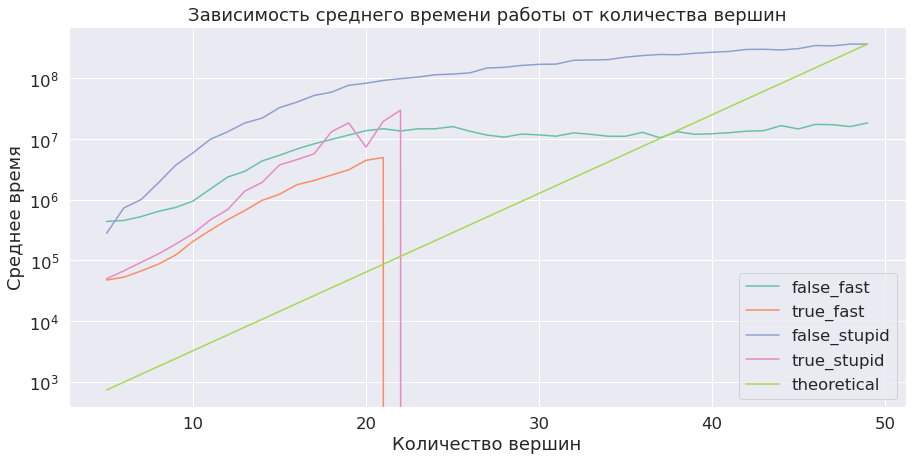

  0%|          | 0/45 [00:00<?, ?it/s]

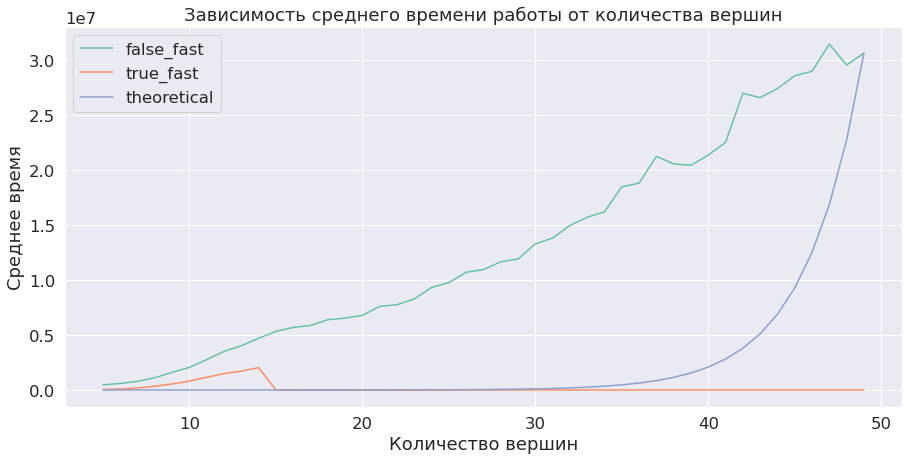

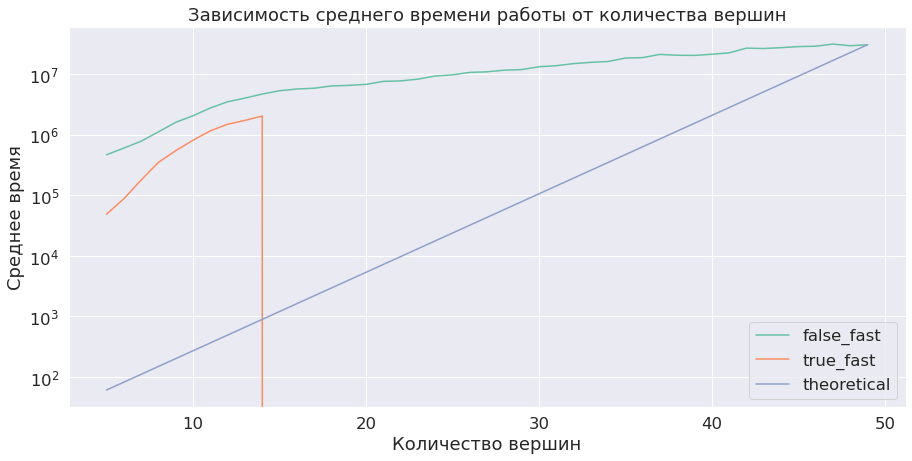

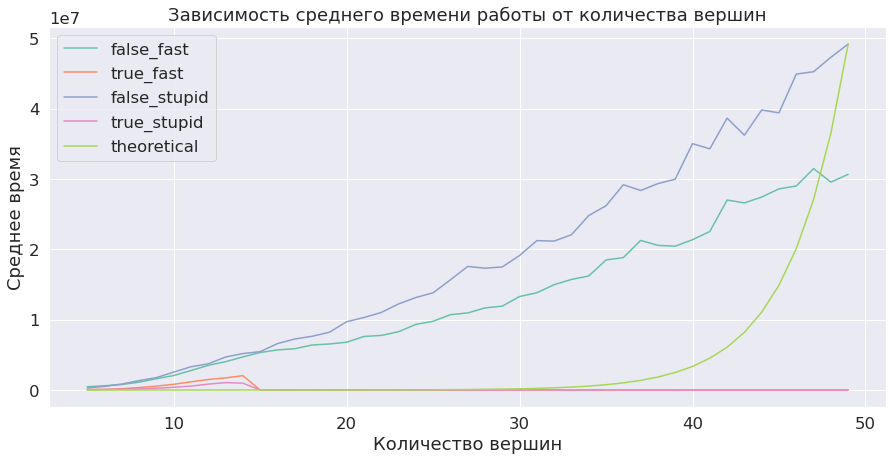

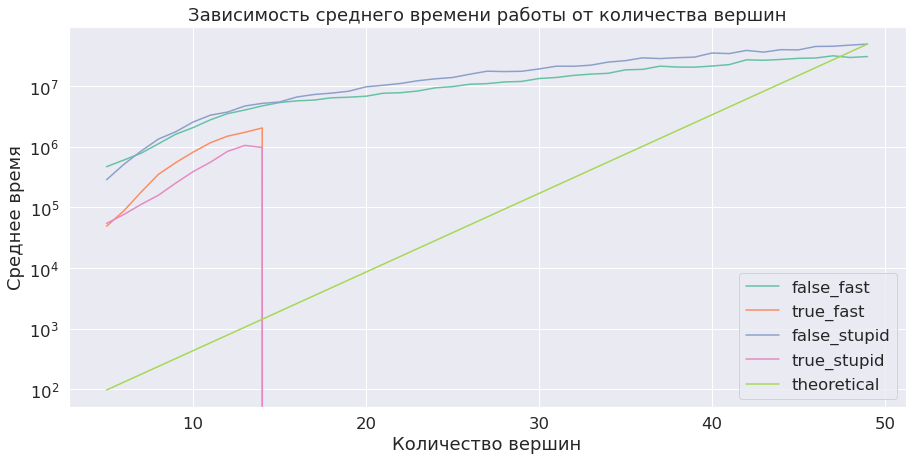

  0%|          | 0/45 [00:00<?, ?it/s]

In [ ]:
for p, max_n in zip([0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 0.99], [50, 30, 50, 50, 50, 50, 50]):
    draw_plots(p, 1000, max_n=max_n)

  0%|          | 0/45 [00:00<?, ?it/s]

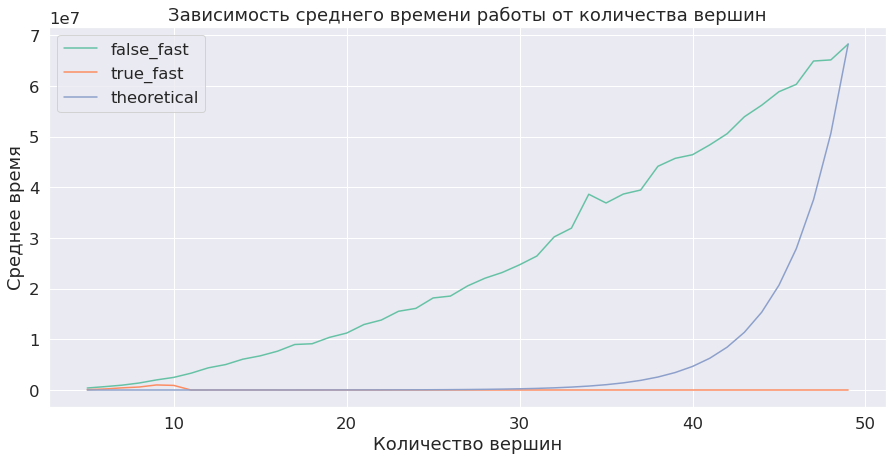

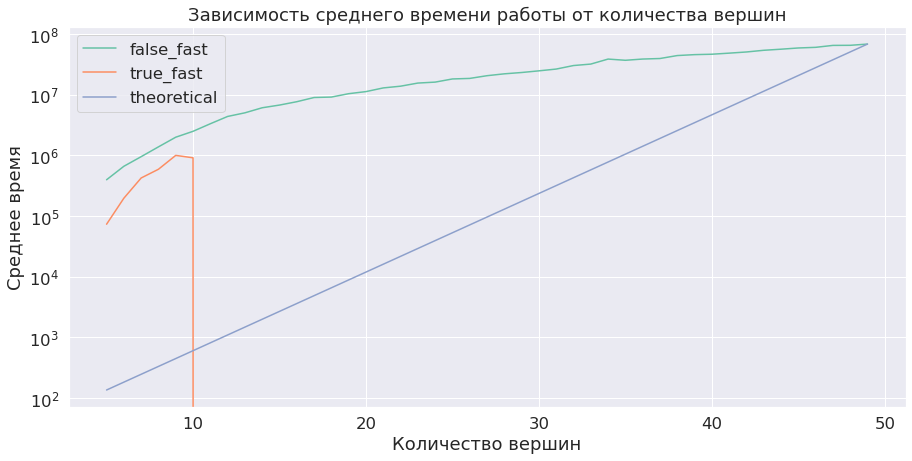

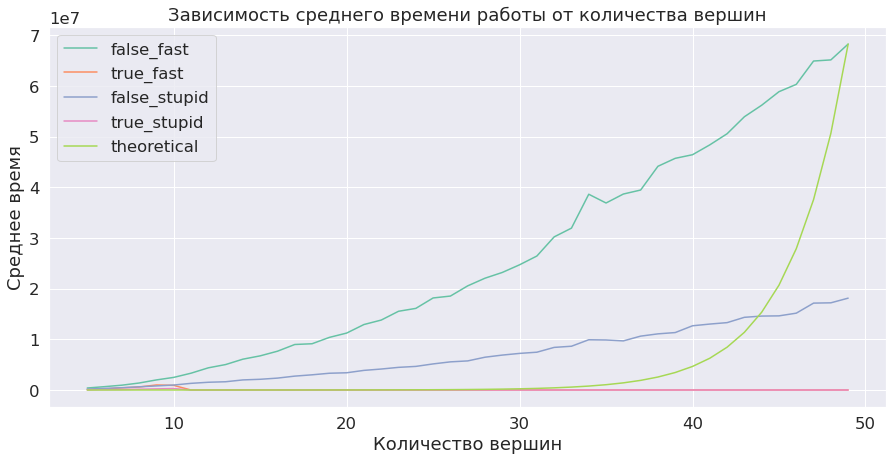

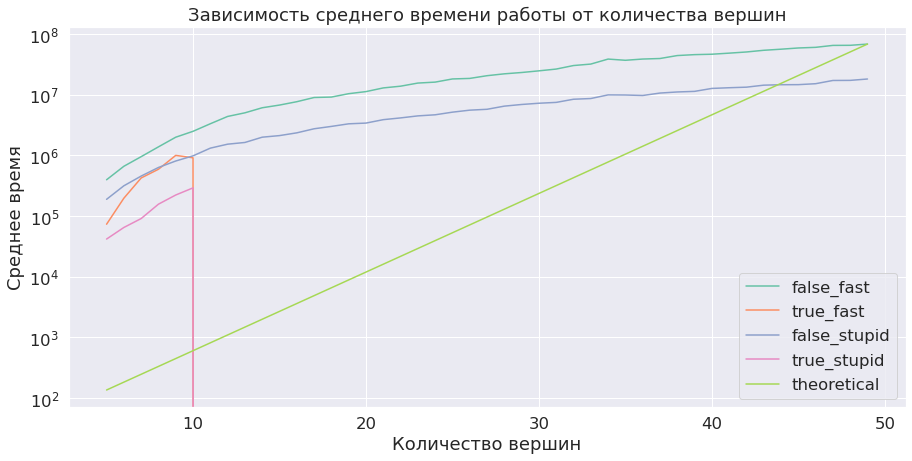

  0%|          | 0/45 [00:00<?, ?it/s]

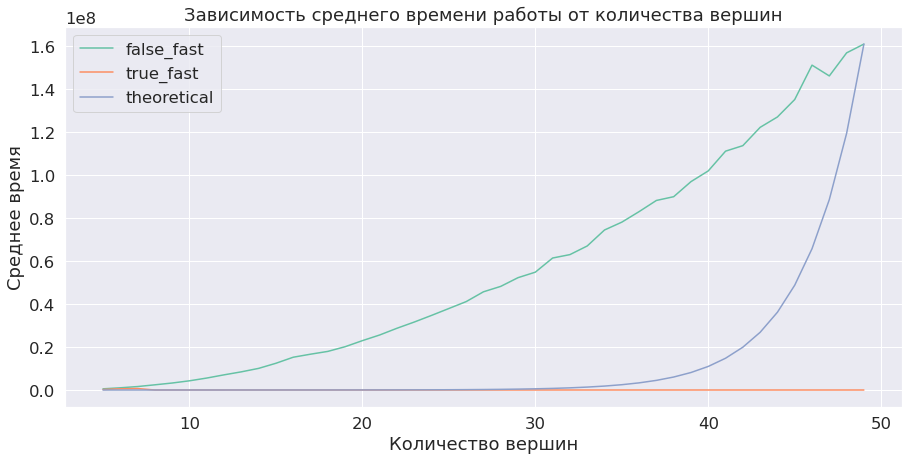

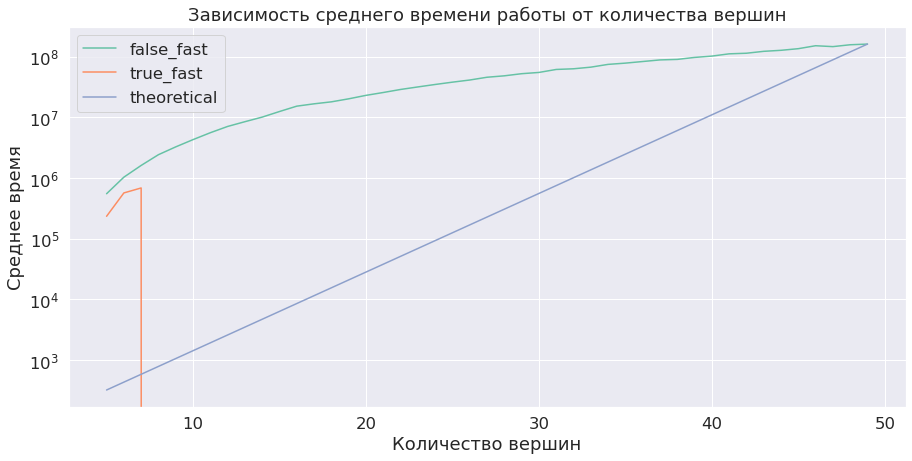

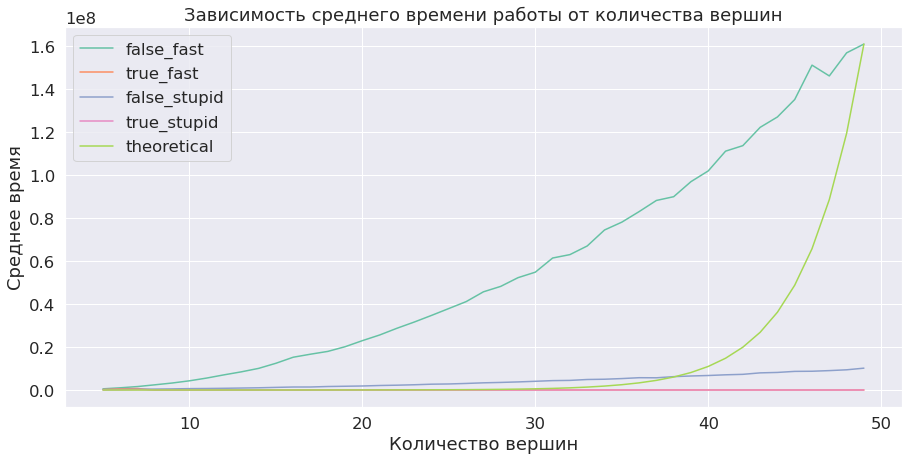

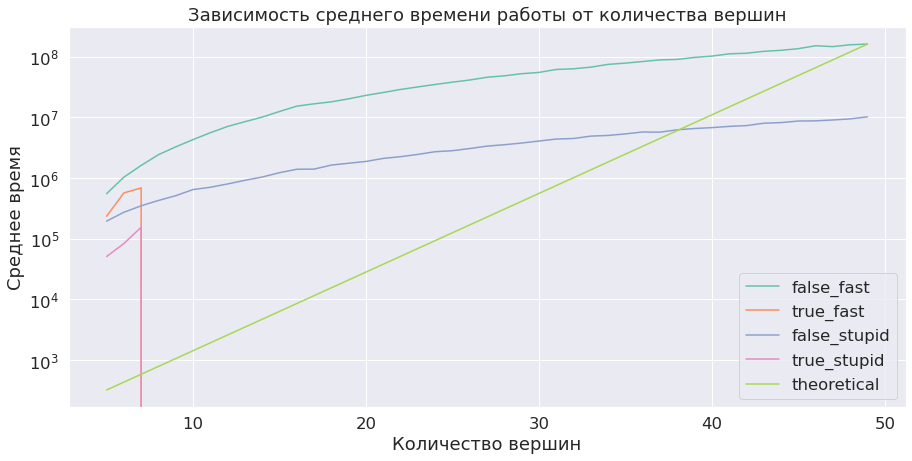

  0%|          | 0/45 [00:00<?, ?it/s]

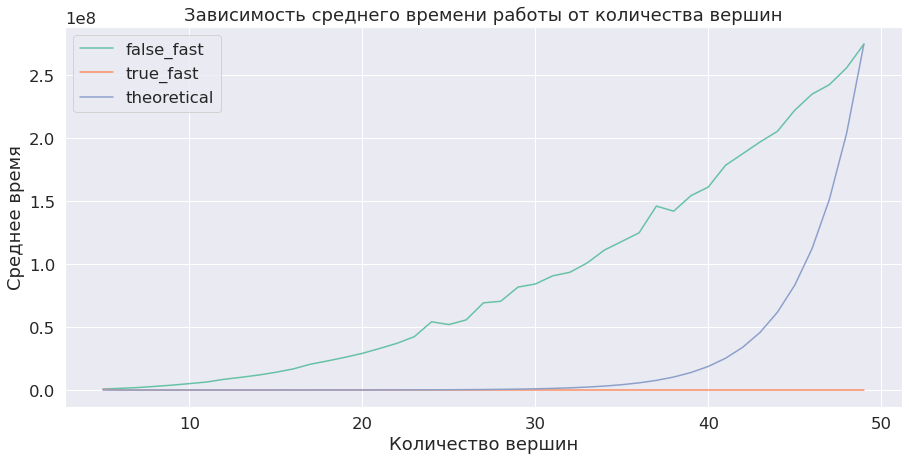

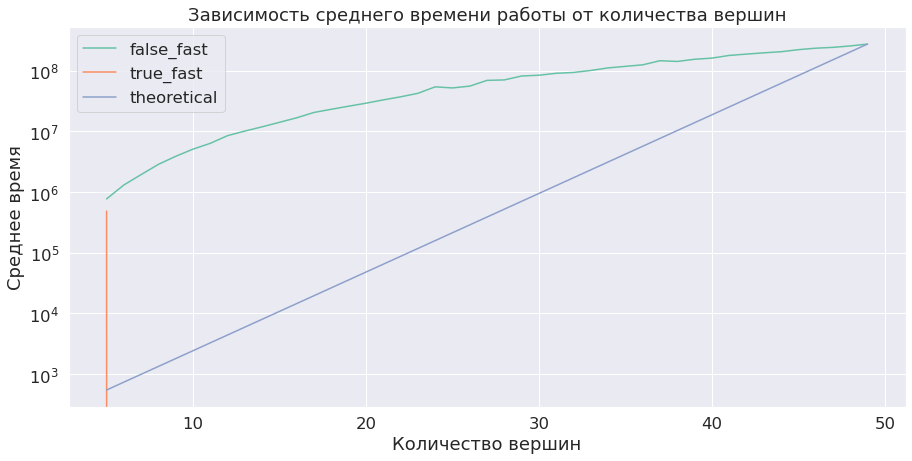

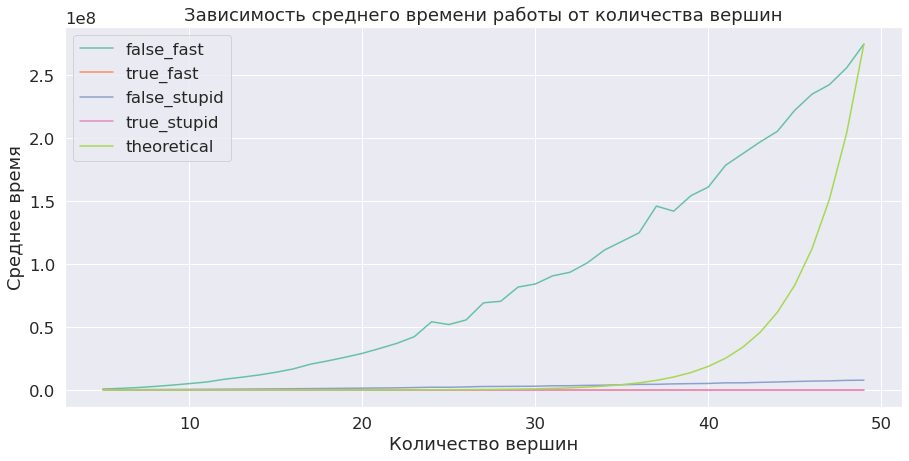

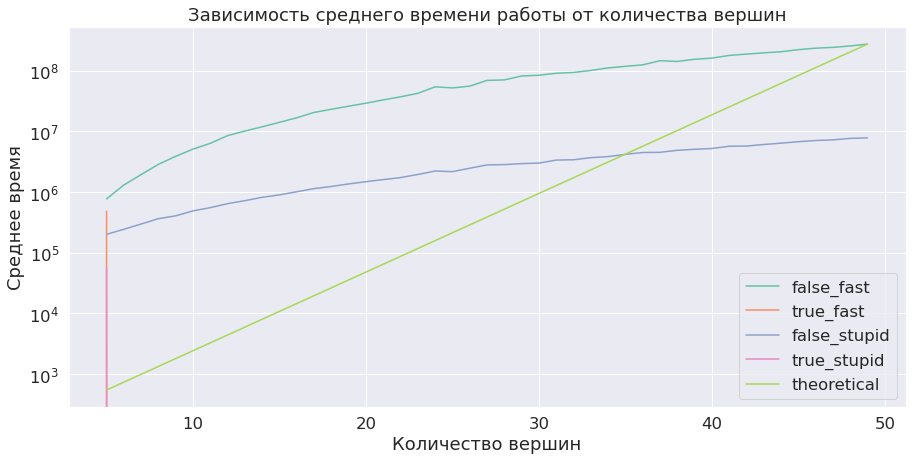

In [5]:
for p, max_n in zip([0.7, 0.9, 0.99], [50, 50, 50]):
    draw_plots(p, 1000, max_n=max_n)